# Calculate recuperated mass from flow
> Ricardo Peres, Jun 2022

Once recuperating from the gas phase, it's quite usefull to know how much xenon is being storaged. This notebook takes output files from Grafana, calculates and plots the ammount of xenon recuperated in gas over time.

In the case of Xenoscope, this method only works if the one and only path from cryostat to bottle array is through the flow meter.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [38]:
R = 0.0831446261815324 #bar.L.K-1.mol-1
M_Xe = 0.131293 #kg.mol-1
#T = 300 #K
#P = 1.85 #bar

In [39]:
@np.vectorize
def LPM(slpm, T, P):
    '''
    Convert standard litters per minute (slpm)
    to litter per minute. Assumes ideal gas law.
      * slpm - flow of gas
      * T - temperature of gas in K
      * P - pressure of gas in bar
    '''
    return slpm * T / 273.15 / P

@np.vectorize
def mass(V, T, P):
    '''
    Calculates the mass of Xenon in a volume at
    a given temperature and pressure using the
    ideal gas law.
      * V - volume of gas in L
      * T - temperature of the gas in K
      * P - pressure of the gas in bar
      '''
    return M_Xe * P * V / R / T

Input the files from Grafana exported with timestamps.

In [6]:
FM = pd.read_csv('/mnt/c/Users/ricmp/Desktop/flow_meter_07_06_2022.csv')
P04 = pd.read_csv('/mnt/c/Users/ricmp/Desktop/PT04_07_06_2022.csv')

In [20]:
df = pd.merge(FM, P04, on = 'Time')
df.rename(columns = {'FM01':'flow', 
                     'PT04 (max 4 bar)':'P'}, 
          inplace = True)
df['Time'] = np.float64(df['Time']/1000)
df['datetime'] = pd.to_datetime(df['Time'], unit = 's') + pd.Timedelta(hours=2)
df['minutes_since_start'] = (df['Time']-df['Time'].iloc[0])/60
df['cumsum_flow'] = np.cumsum(df['flow'])
df.head()

,Time,flow,P,datetime,minutes_since_start,cumsum_flow
0,1.654587e+09,-0.07,1.717303,2022-06-07 09:38:00,0.0,-0.07
1,1.654588e+09,-0.06,1.718461,2022-06-07 09:40:00,2.0,-0.13
2,1.654588e+09,-0.06,1.720341,2022-06-07 09:42:00,4.0,-0.19
3,1.654588e+09,-0.06,1.721933,2022-06-07 09:44:00,6.0,-0.25
4,1.654588e+09,-0.06,1.729601,2022-06-07 09:46:00,8.0,-0.31


### Simple plots

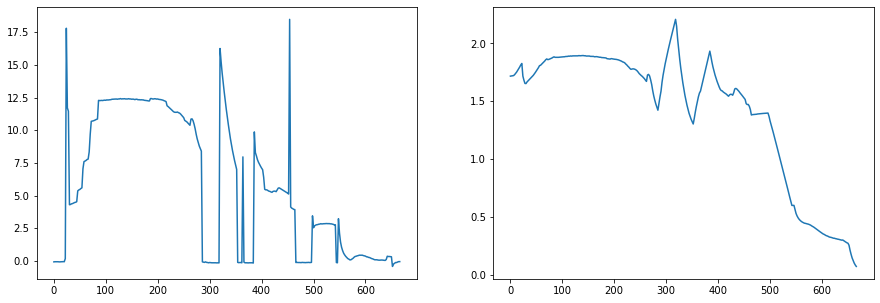

In [9]:
fig, axs = plt.subplots(1,2,figsize = (15,5))
axs[0].plot(df['minutes_since_start'], df['flow'])
axs[1].plot(df['minutes_since_start'], df['P'])

plt.show()

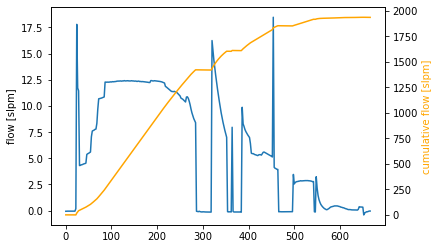

In [10]:
fig, ax = plt.subplots()
ax.plot(df['minutes_since_start'], df['flow'])
ax.set_ylabel('flow [slpm]')
ax2 = ax.twinx()
ax2.plot(df['minutes_since_start'], df['cumsum_flow'], color = 'orange')
ax2.set_ylabel('cumulative flow [slpm]', color = 'orange')
plt.show()

In [22]:
df['flow_LPM'] = LPM(df['flow'], 300, df['P'])
df['cumsum_flow_LPM'] = np.cumsum(df['flow_LPM'])

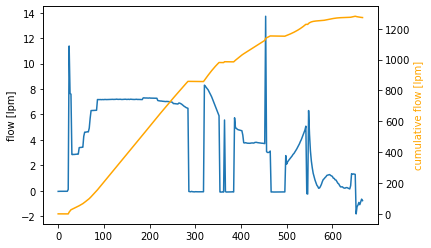

In [12]:
fig, ax = plt.subplots()
ax.plot(df['minutes_since_start'], df['flow_LPM'])
ax.set_ylabel('flow [lpm]')
ax2 = ax.twinx()
#ax2.plot(df['minutes_since_start'], LPM(df['cumsum_flow'], 300, df['P']), color = 'orange')
ax2.plot(df['minutes_since_start'],df['cumsum_flow_LPM'], color = 'orange')
ax2.set_ylabel('cumulative flow [lpm]', color = 'orange')
plt.show()

In [33]:
df['dt'] = np.insert(np.diff(df['Time']), 0, 0)
df['mass_recuperated_in_dt'] = mass(V = df['dt']/60 * df['flow_LPM'] ,
                              T = 300, 
                              P = df['P'])
df['total_mass_recuperated'] = np.cumsum(df['mass_recuperated_in_dt'])

In [36]:
df.tail(1)

,Time,flow,P,datetime,minutes_since_start,cumsum_flow,dt,flow_LPM,cumsum_flow_LPM,mass_recuperated_in_dt,total_mass_recuperated
333,1.654627e+09,-0.05,0.071036,2022-06-07 20:44:00,666.0,1935.19,120.0,-0.773058,1272.003827,-0.000578,22.375642


## Main plot

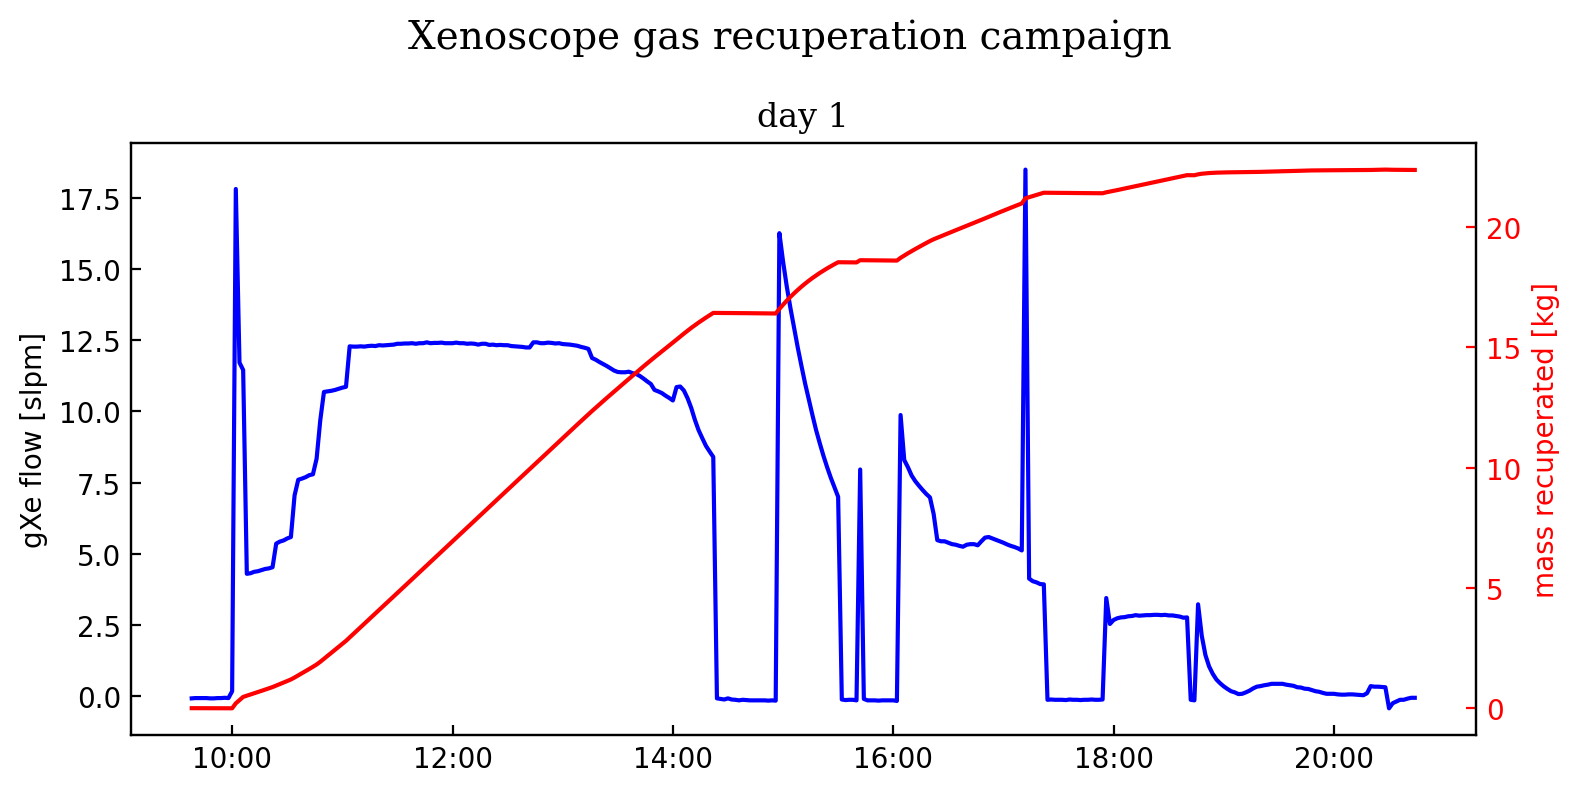

In [37]:
fig, ax = plt.subplots(figsize =(8,4), dpi = 200,facecolor='white')
fig.suptitle('Xenoscope gas recuperation campaign', fontfamily='serif', fontsize = 14)
ax.set_title('day 1', fontfamily='serif', fontsize = 12)

ax.plot(df['datetime'], df['flow'],color = 'blue')

ax.set_ylabel('gXe flow [slpm]')
ax.tick_params(axis='both',direction="in")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax.twinx()

ax2.plot(df['datetime'], df['total_mass_recuperated'], color = 'red')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.tick_params(axis='y', colors='red',direction="in",)
ax2.set_ylabel('mass recuperated [kg]', color = 'red')

plt.tight_layout()
#plt.savefig('recuperation_day1.png')
plt.show()